In [37]:
import requests
import time
import execjs
import matplotlib.pyplot as plt
# from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import pandas as pd
import numpy as np
import os
from multiprocessing import Process

In [42]:
def getUrl(fscode):
    head = 'http://fund.eastmoney.com/pingzhongdata/'
    tail = '.js?v='+ time.strftime("%Y%m%d%H%M%S",time.localtime())

    return head+fscode+tail

In [43]:
def getAllCode():
    url = 'http://fund.eastmoney.com/js/fundcode_search.js'
    content = requests.get(url)
    jsContent = execjs.compile(content.text)
    rawData = jsContent.eval('r')
    allCode = []
    for code in rawData:
        allCode.append(code[0])
    return allCode
allCode = getAllCode()

In [143]:
# 获取 js 数据
def getWorth(fscode):
    #用requests获取到对应的文件
    content = requests.get(getUrl(fscode))

    #使用execjs获取到相应的数据
    jsContent = execjs.compile(content.text)
    #     print(type(jsContent))
    name = jsContent.eval('fS_name')
    code = jsContent.eval('fS_code')
    fund_sourceRate = jsContent.eval('fund_sourceRate')
    fund_Rate = jsContent.eval('fund_Rate')
    fund_minsg = jsContent.eval('fund_minsg')
#     try:
    stockCodes = jsContent.eval('stockCodes')
#     except:
#         stockCodes = ""
    zqCodes = jsContent.eval('zqCodes')
    syl_1n = jsContent.eval('syl_1n')
    syl_6y = jsContent.eval('syl_6y')
    syl_3y = jsContent.eval('syl_3y')
    syl_1y = jsContent.eval('syl_1y')

    netWorthTrend = jsContent.eval('Data_netWorthTrend')  # 单位净值走势
    aCWorthTrend = jsContent.eval('Data_ACWorthTrend')  # 累计净值走势
    grandTotal = jsContent.eval('Data_grandTotal')  # 累计收益率走势
    rateInSimilarType = jsContent.eval('Data_rateInSimilarType')  # 同类排名走势
    rateInSimilarPersent = jsContent.eval(
        'Data_rateInSimilarPersent')  # 同类排名百分比
    fluctuationScale = jsContent.eval(
        'Data_fluctuationScale')  # 规模变动 mom-较上期环比
    holderStructure = jsContent.eval('Data_holderStructure')  # 持有人结构
    assetAllocation = jsContent.eval('Data_assetAllocation')  # 资产配置
    performanceEvaluation = jsContent.eval(
        'Data_performanceEvaluation'
    )  # 业绩评价 ['选股能力', '收益率', '抗风险', '稳定性','择时能力']
    currentFundManager = jsContent.eval(
        'Data_currentFundManager')  # 现任基金经理  多个表示有多个经理
    buySedemption = jsContent.eval('Data_buySedemption')  # 申购赎回

    basic_info_pd = pd.DataFrame(data=
        [[name, code, fund_sourceRate, fund_Rate, fund_minsg,
         syl_1n, syl_6y, syl_3y, syl_1y]],
        columns=[
            "name", "code", "原费率", "现费率", "最小申购金额",
            "近一年收益率", "近6月收益率", "近三月收益率", "近一月收益率"
        ])

    stockCodesList = []
    zqCodesList = []
    netWorthList = []
    ACWorthList = []
    grandTotalList = []
    rateInSimilarTypeList = []
    rateInSimilarPersentList = []
    fluctuationScaleList = []
    holderStructureList = []
    assetAllocationList = []
    performanceEvaluationList = []
    currentFundManagerList = []
    buySedemptionList = []

    for sc in stockCodes[::-1]:
        stockCodesList.append(sc)
    stockCodesList = stockCodes
    for zq in zqCodes.split(","):
        zqCodesList.append(zq)

    #  单位净值走势  提取各数组
    for dayWorth in netWorthTrend[::-1]:
        netWorthList.append([
            dayWorth['x'], dayWorth['y'], dayWorth['equityReturn'],
            dayWorth['unitMoney']
        ])

#   2*-1
    for dayACWorth in aCWorthTrend[::-1]:
        ACWorthList.append([dayACWorth[0], dayACWorth[1]])

#   3*2*126
    for dayGrandTotal in grandTotal[::-1]:
        gname = dayGrandTotal['name']
        dataList = []
        for data in dayGrandTotal['data']:
            dataList.append([data[0], data[1]])
        grandTotalList.append([gname, dataList])

    for dayRateInSimilarType in rateInSimilarType[::-1]:
        rateInSimilarTypeList.append([
            dayRateInSimilarType['x'], dayRateInSimilarType['y'],
            dayRateInSimilarType['sc']
        ])

    for dayRateInSimilarPersent in rateInSimilarPersent[::-1]:
        rateInSimilarPersentList.append(dayRateInSimilarPersent[1])

#     规模变动 环比，categories= 环比日期，y=净资产亿元， mom=净资产变动率
    fs_c = fluctuationScale.get('categories')
    fs_s = fluctuationScale.get('series')
    for i in range(len(fs_c)):
        fluctuationScaleList.append([fs_c[i], fs_s[i]["y"], fs_s[i]["mom"]])

#     持有人结构 每个持有比在四个日期下的具体比例，categories= 环比日期，name=名称，data=数据
    hs_c = holderStructure.get('categories')
    hs_s = holderStructure.get('series')
    for i in range(len(hs_s)):
        hs_s_n = hs_s[i]["name"]
        hs_c_d = []
        for j in range(len(hs_c)):
            hs_c_d.append([hs_c[j], hs_s[i]['data'][j]])
        holderStructureList.append([hs_s_n, hs_c_d])

#    资产配置 每个名称的配置再不同日期下的占净比，净资产额度
    aa_s = assetAllocation.get('series')
    aa_c = assetAllocation.get('categories')
    for i in range(len(aa_s)):
        aa_s_n = aa_s[i]["name"]
        aa_c_d = []
        for j in range(len(aa_c)):
            aa_c_d.append([aa_c[j], aa_s[i]['data'][j]])
        assetAllocationList.append([aa_s_n, aa_c_d])

#    业绩评价  ['选股能力', '收益率', '抗风险', '稳定性','择时能力']
    pe_avr = performanceEvaluation.get('avr')
#     performanceEvaluationList.append(pe_avr)
    pe_c = performanceEvaluation.get('categories')
    pe_dsc = performanceEvaluation.get('dsc')
    pe_data = performanceEvaluation.get('data')
    pe_c_d_d = [["平均值",pe_avr,"平均值"]]
    for i in range(len(pe_c)):
        pe_c_d_d.append([pe_c[i], pe_data[i], pe_dsc[i]])
    
    performanceEvaluationList.append(pe_c_d_d)

    #   现任基金经理
    for cfm in currentFundManager[::-1]:
        fm_id = cfm.get("id")
        fm_name = cfm.get("name")
        fm_star = cfm.get("star")
        fm_workTime = cfm.get("workTime")
        fm_fundSize = cfm.get("fundSize")
        #         power
        fm_power = cfm.get("power")
        fm_power_list = []
        fm_power_avr = fm_power.get('avr')
        fm_power_jzrq = fm_power.get('jzrq')  # 截止日期
        fm_c = fm_power.get('categories')
        fm_dsc = fm_power.get('dsc')
        fm_data = fm_power.get('data')
        for i in range(len(fm_c)):
            fm_power_list.append([fm_c[i], fm_dsc[i], fm_data[i]])


#         profit
        fm_profit = cfm.get("profit")
        fm_profit_list = []
        fm_profit_c = fm_profit.get('categories')
        fm_profit_s_d = fm_profit.get('series')[0]["data"]
        for i in range(len(fm_profit_s_d)):
            fm_profit_list.append([fm_profit_c[i], fm_profit_s_d[i]["y"]])

        currentFundManagerList.append([
            fm_id, fm_name, fm_star, fm_workTime, fm_fundSize, fm_power_avr,
            fm_power_jzrq, fm_power_list, fm_profit_list
        ])

    #    申购赎回 每个日期的操作量
    bs_s = buySedemption.get('series')
    bs_c = buySedemption.get('categories')
    for i in range(len(bs_s)):
        bs_s_n = bs_s[i]["name"]
        bs_c_d = []
        for j in range(len(bs_c)):
            bs_c_d.append([bs_c[j], bs_s[i]['data'][j]])
        buySedemptionList.append([bs_s_n, bs_c_d])

    print(name, code)
    return code, basic_info_pd, [
        stockCodesList, zqCodesList, netWorthList, ACWorthList, grandTotalList,
        rateInSimilarTypeList, rateInSimilarPersentList, fluctuationScaleList,
        holderStructureList, assetAllocationList, performanceEvaluationList,
        currentFundManagerList, buySedemptionList
    ]

In [62]:
# 到 df 里处理，再保存
def df_to_csv(code, basic_info_pd, funds):

    # 数据合并到DF
    basic_info_pd.reset_index(drop=True)

    stockCodesDF = pd.DataFrame([[funds[0]]], columns=['基金持仓股票代码'])
    zqCodesDF = pd.DataFrame([[funds[1]]], columns=['基金持仓债券代码'])

    netWorthDF = pd.DataFrame(
        funds[2], columns=['时间戳', '单位净值', '净值回报', '每份派送金'])
    ACWorthDF = pd.DataFrame(funds[3], columns=['时间戳', '累计净值'])
    grandTotalDF = pd.DataFrame(funds[4], columns=['累计收益率名称', '累计收益率信息'])
    for i in range(len(grandTotalDF['累计收益率信息'])):
        grandTotalDF['累计收益率信息'][i] = pd.DataFrame(
            grandTotalDF['累计收益率信息'][i],
            columns=['时间戳', grandTotalDF['累计收益率名称'][i] + '累计收益率'])

    rateInSimilarTypeDF = pd.DataFrame(funds[5], columns=['时间戳', '排名', 'sc'])
    rateInSimilarPersentDF = pd.DataFrame(funds[6], columns=['同类排名百分比'])
    fluctuationScaleDF = pd.DataFrame(
        funds[7], columns=['规模变动日期', "规模变动净资产亿元", "规模变动较上期环比"])

    # 已平
    holderStructureDF = pd.DataFrame(funds[8], columns=['持有信息日期', '持有信息'])
    for i in range(len(holderStructureDF['持有信息'])):
        holderStructureDF['持有信息'][i] = pd.DataFrame(
            holderStructureDF['持有信息'][i], columns=["持有比名称", "比例"])
    holderStructureDF = holderStructureDF.T
    holderStructureDF.reset_index(drop=True, inplace=True)
    holderStructureDF.columns = holderStructureDF[:1].values.tolist()
    holderStructureDF = holderStructureDF.drop(0)
    holderStructureDF = holderStructureDF.reset_index(drop=True)

    # 已平
    assetAllocationDF = pd.DataFrame(funds[9], columns=['名称', '资产配置名称'])
    for i in range(len(assetAllocationDF['资产配置名称'])):
        assetAllocationDF['资产配置名称'][i] = pd.DataFrame(
            assetAllocationDF['资产配置名称'][i], columns=["时间", "比例"])
    assetAllocationDF = assetAllocationDF.T
    assetAllocationDF.reset_index(drop=True, inplace=True)
    assetAllocationDF.columns = assetAllocationDF[:1].values.tolist()
    assetAllocationDF = assetAllocationDF.drop(0)
    assetAllocationDF = assetAllocationDF.reset_index(drop=True)

    # 已平
    performanceEvaluationDF = pd.DataFrame(funds[10]).T
    performanceEvaluationDF = performanceEvaluationDF[0].apply(pd.Series)
    performanceEvaluationDF.columns = ["业绩评价名称", "分数", "描述"]
    performanceEvaluationDF = performanceEvaluationDF.T
    performanceEvaluationDF.reset_index(drop=True, inplace=True)
    performanceEvaluationDF.columns = performanceEvaluationDF[:
                                                              1].values.tolist(
                                                              )
    performanceEvaluationDF = performanceEvaluationDF.drop(0)
    performanceEvaluationDF = performanceEvaluationDF.drop(2)
    performanceEvaluationDF = performanceEvaluationDF.reset_index(drop=True)

    # 现任基金经理 已平,但有两行
    power_pd = pd.DataFrame()
    profit_pd = pd.DataFrame()
    currentFundManagerDF = pd.DataFrame(
        funds[11],
        columns=[
            'id', '姓名', '星级', '工作时间', '资金/基金数', '平均分', '截止日期', '评分', '收益能力'
        ])

    for i in range(len(currentFundManagerDF["id"])):
        power = pd.DataFrame(currentFundManagerDF['评分'][i]).T
        power = power.drop(1)  # 删除描述
        power.columns = power[:1].values.tolist()  # 重命名列名
        power = power.drop(0)
        power.reset_index(drop=True, inplace=True)
        power_pd = pd.concat([power_pd, power])
        power_pd.reset_index(drop=True, inplace=True)

        profit = pd.DataFrame(currentFundManagerDF['收益能力'][i]).T
        profit.columns = profit[:1].values.tolist()  # 重命名列名
        profit = profit.drop(0)
        profit.reset_index(drop=True, inplace=True)
        profit_pd = pd.concat([profit_pd, profit])
        profit_pd.reset_index(drop=True, inplace=True)

    currentFundManagerDF = pd.concat([currentFundManagerDF, power_pd], axis=1)
    currentFundManagerDF = pd.concat([currentFundManagerDF, profit_pd], axis=1)
    currentFundManagerDF = currentFundManagerDF.drop(['评分', '收益能力'], axis=1)
    currentFundManagerDF = pd.DataFrame([currentFundManagerDF.T])

    # 申购赎回 # 已平
    buySedemptionDF = pd.DataFrame(funds[12], columns=['申购赎回日期', '申购赎回信息'])
    for i in range(len(buySedemptionDF['申购赎回信息'])):
        buySedemptionDF['申购赎回信息'][i] = pd.DataFrame(
            buySedemptionDF['申购赎回信息'][i], columns=["时间", "份额"])
    buySedemptionDF = buySedemptionDF.T
    buySedemptionDF.reset_index(drop=True, inplace=True)
    buySedemptionDF.columns = buySedemptionDF[:1].values.tolist()
    buySedemptionDF = buySedemptionDF.drop(0)
    buySedemptionDF = buySedemptionDF.reset_index(drop=True)

    # 合并到最终宽窄两表
    # 建立宽表 合并
    fund_wide_pd = pd.DataFrame()
    fund_wide_pd = pd.concat([fund_wide_pd, basic_info_pd], axis=1)
    fund_wide_pd = pd.concat([fund_wide_pd, stockCodesDF], axis=1)  #
    fund_wide_pd = pd.concat([fund_wide_pd, zqCodesDF], axis=1)  #
    fund_wide_pd = pd.concat([
        fund_wide_pd,
        pd.DataFrame([[fluctuationScaleDF["规模变动日期"].values.tolist()]],
                     columns=["规模变动日期"])
    ],
                             axis=1)
    fund_wide_pd = pd.concat([
        fund_wide_pd,
        pd.DataFrame([[fluctuationScaleDF["规模变动净资产亿元"].values.tolist()]],
                     columns=["规模变动净资产亿元"])
    ],
                             axis=1)
    fund_wide_pd = pd.concat([
        fund_wide_pd,
        pd.DataFrame([[fluctuationScaleDF["规模变动较上期环比"].values.tolist()]],
                     columns=["规模变动较上期环比"])
    ],
                             axis=1)
    fund_wide_pd = pd.concat([fund_wide_pd, holderStructureDF], axis=1)
    fund_wide_pd = pd.concat([fund_wide_pd, assetAllocationDF], axis=1)
    fund_wide_pd = pd.concat([fund_wide_pd, performanceEvaluationDF], axis=1)
    fund_wide_pd = pd.concat([fund_wide_pd, currentFundManagerDF], axis=1)
    fund_wide_pd.rename(columns={0: "经理"}, inplace=True)
    fund_wide_pd = pd.concat([fund_wide_pd, buySedemptionDF], axis=1)

    # 窄表
    fund_narrow_pd = pd.DataFrame()
    fund_narrow_pd = pd.concat([fund_narrow_pd, rateInSimilarTypeDF], axis=1)
    fund_narrow_pd = pd.concat([fund_narrow_pd, rateInSimilarPersentDF],
                               axis=1)
    fund_narrow_pd = pd.merge(fund_narrow_pd, netWorthDF, how='outer')
    fund_narrow_pd = pd.merge(fund_narrow_pd, ACWorthDF, how='outer')

    for i in range(len(grandTotalDF['累计收益率信息'])):
        fund_narrow_pd = pd.merge(
            fund_narrow_pd, grandTotalDF['累计收益率信息'][i], how='outer')

    fund_narrow_pd = pd.DataFrame(fund_narrow_pd.T)
    fund_narrow_pd.insert(0, 'code', code)



    fund_wide_pd.to_csv(
        './fund_wide_pd.csv',
        encoding='utf_8_sig',
        mode='a',
        header=False,
        index=False)

    fund_narrow_pd.to_csv(
        './fund_narrow_pd.csv', encoding='utf_8_sig', mode='a', header=False)

# 多进程用
def df_to_csv_m(code, basic_info_pd, funds, mid):
    # 数据合并到DF
    basic_info_pd.reset_index(drop=True)

    stockCodesDF = pd.DataFrame([[funds[0]]], columns=['基金持仓股票代码'])
    zqCodesDF = pd.DataFrame([[funds[1]]], columns=['基金持仓债券代码'])

    netWorthDF = pd.DataFrame(
        funds[2], columns=['时间戳', '单位净值', '净值回报', '每份派送金'])
    ACWorthDF = pd.DataFrame(funds[3], columns=['时间戳', '累计净值'])
    grandTotalDF = pd.DataFrame(funds[4], columns=['累计收益率名称', '累计收益率信息'])
    for i in range(len(grandTotalDF['累计收益率信息'])):
        grandTotalDF['累计收益率信息'][i] = pd.DataFrame(
            grandTotalDF['累计收益率信息'][i],
            columns=['时间戳', grandTotalDF['累计收益率名称'][i] + '累计收益率'])

    rateInSimilarTypeDF = pd.DataFrame(funds[5], columns=['时间戳', '排名', 'sc'])
    rateInSimilarPersentDF = pd.DataFrame(funds[6], columns=['同类排名百分比'])
    fluctuationScaleDF = pd.DataFrame(
        funds[7], columns=['规模变动日期', "规模变动净资产亿元", "规模变动较上期环比"])

    # 已平
    holderStructureDF = pd.DataFrame(funds[8], columns=['持有信息日期', '持有信息'])
    for i in range(len(holderStructureDF['持有信息'])):
        holderStructureDF['持有信息'][i] = pd.DataFrame(
            holderStructureDF['持有信息'][i], columns=["持有比名称", "比例"])
    holderStructureDF = holderStructureDF.T
    holderStructureDF.reset_index(drop=True, inplace=True)
    holderStructureDF.columns = holderStructureDF[:1].values.tolist()
    holderStructureDF = holderStructureDF.drop(0)
    holderStructureDF = holderStructureDF.reset_index(drop=True)

    # 已平
    assetAllocationDF = pd.DataFrame(funds[9], columns=['名称', '资产配置名称'])
    for i in range(len(assetAllocationDF['资产配置名称'])):
        assetAllocationDF['资产配置名称'][i] = pd.DataFrame(
            assetAllocationDF['资产配置名称'][i], columns=["时间", "比例"])
    assetAllocationDF = assetAllocationDF.T
    assetAllocationDF.reset_index(drop=True, inplace=True)
    assetAllocationDF.columns = assetAllocationDF[:1].values.tolist()
    assetAllocationDF = assetAllocationDF.drop(0)
    assetAllocationDF = assetAllocationDF.reset_index(drop=True)

    # 已平
    performanceEvaluationDF = pd.DataFrame(funds[10]).T
    performanceEvaluationDF = performanceEvaluationDF[0].apply(pd.Series)
    performanceEvaluationDF.columns = ["业绩评价名称", "分数", "描述"]
    performanceEvaluationDF = performanceEvaluationDF.T
    performanceEvaluationDF.reset_index(drop=True, inplace=True)
    performanceEvaluationDF.columns = performanceEvaluationDF[:
                                                              1].values.tolist(
                                                              )
    performanceEvaluationDF = performanceEvaluationDF.drop(0)
    performanceEvaluationDF = performanceEvaluationDF.drop(2)
    performanceEvaluationDF = performanceEvaluationDF.reset_index(drop=True)

    # 现任基金经理 已平,但有两行
    power_pd = pd.DataFrame()
    profit_pd = pd.DataFrame()
    currentFundManagerDF = pd.DataFrame(
        funds[11],
        columns=[
            'id', '姓名', '星级', '工作时间', '资金/基金数', '平均分', '截止日期', '评分', '收益能力'
        ])

    for i in range(len(currentFundManagerDF["id"])):
        power = pd.DataFrame(currentFundManagerDF['评分'][i]).T
        power = power.drop(1)  # 删除描述
        power.columns = power[:1].values.tolist()  # 重命名列名
        power = power.drop(0)
        power.reset_index(drop=True, inplace=True)
        power_pd = pd.concat([power_pd, power])
        power_pd.reset_index(drop=True, inplace=True)

        profit = pd.DataFrame(currentFundManagerDF['收益能力'][i]).T
        profit.columns = profit[:1].values.tolist()  # 重命名列名
        profit = profit.drop(0)
        profit.reset_index(drop=True, inplace=True)
        profit_pd = pd.concat([profit_pd, profit])
        profit_pd.reset_index(drop=True, inplace=True)

    currentFundManagerDF = pd.concat([currentFundManagerDF, power_pd], axis=1)
    currentFundManagerDF = pd.concat([currentFundManagerDF, profit_pd], axis=1)
    currentFundManagerDF = currentFundManagerDF.drop(['评分', '收益能力'], axis=1)
    currentFundManagerDF = pd.DataFrame([currentFundManagerDF.T])

    # 申购赎回 # 已平
    buySedemptionDF = pd.DataFrame(funds[12], columns=['申购赎回日期', '申购赎回信息'])
    for i in range(len(buySedemptionDF['申购赎回信息'])):
        buySedemptionDF['申购赎回信息'][i] = pd.DataFrame(
            buySedemptionDF['申购赎回信息'][i], columns=["时间", "份额"])
    buySedemptionDF = buySedemptionDF.T
    buySedemptionDF.reset_index(drop=True, inplace=True)
    buySedemptionDF.columns = buySedemptionDF[:1].values.tolist()
    buySedemptionDF = buySedemptionDF.drop(0)
    buySedemptionDF = buySedemptionDF.reset_index(drop=True)

    # 合并到最终宽窄两表
    # 建立宽表 合并
    fund_wide_pd = pd.DataFrame()
    fund_wide_pd = pd.concat([fund_wide_pd, basic_info_pd], axis=1)
    fund_wide_pd = pd.concat([fund_wide_pd, stockCodesDF], axis=1)  #
    fund_wide_pd = pd.concat([fund_wide_pd, zqCodesDF], axis=1)  #
    fund_wide_pd = pd.concat([
        fund_wide_pd,
        pd.DataFrame([[fluctuationScaleDF["规模变动日期"].values.tolist()]],
                     columns=["规模变动日期"])
    ],
                             axis=1)
    fund_wide_pd = pd.concat([
        fund_wide_pd,
        pd.DataFrame([[fluctuationScaleDF["规模变动净资产亿元"].values.tolist()]],
                     columns=["规模变动净资产亿元"])
    ],
                             axis=1)
    fund_wide_pd = pd.concat([
        fund_wide_pd,
        pd.DataFrame([[fluctuationScaleDF["规模变动较上期环比"].values.tolist()]],
                     columns=["规模变动较上期环比"])
    ],
                             axis=1)
    fund_wide_pd = pd.concat([fund_wide_pd, holderStructureDF], axis=1)
    fund_wide_pd = pd.concat([fund_wide_pd, assetAllocationDF], axis=1)
    fund_wide_pd = pd.concat([fund_wide_pd, performanceEvaluationDF], axis=1)
    fund_wide_pd = pd.concat([fund_wide_pd, currentFundManagerDF], axis=1)
    fund_wide_pd.rename(columns={0: "经理"}, inplace=True)
    fund_wide_pd = pd.concat([fund_wide_pd, buySedemptionDF], axis=1)

    # 窄表
    fund_narrow_pd = pd.DataFrame()
    fund_narrow_pd = pd.concat([fund_narrow_pd, rateInSimilarTypeDF], axis=1)
    fund_narrow_pd = pd.concat([fund_narrow_pd, rateInSimilarPersentDF],
                               axis=1)
    fund_narrow_pd = pd.merge(fund_narrow_pd, netWorthDF, how='outer')
    fund_narrow_pd = pd.merge(fund_narrow_pd, ACWorthDF, how='outer')

    for i in range(len(grandTotalDF['累计收益率信息'])):
        fund_narrow_pd = pd.merge(
            fund_narrow_pd, grandTotalDF['累计收益率信息'][i], how='outer')

    fund_narrow_pd = pd.DataFrame(fund_narrow_pd.T)
    fund_narrow_pd.insert(0, 'code', code)



    fund_wide_pd.to_csv(
        './fund_wide_pd' + mid + '.csv',
        encoding='utf_8_sig',
        mode='a',
        header=False,
        index=False)
    fund_narrow_pd.to_csv(
        './fund_narrow_pd' + mid + '.csv',
        encoding='utf_8_sig',
        mode='a',
        header=False)

In [73]:
def all_code_m(allCode,mid):
    print("mid",mid)
    # 存在就删除
    if os.path.exists('./fund_narrow_pd' + mid + '.csv'):
        os.remove('./fund_narrow_pd' + mid + '.csv')
    if os.path.exists('./fund_wide_pd' + mid + '.csv'):
        os.remove('./fund_wide_pd' + mid + '.csv')
    for code in allCode:
        try:
            code, basic_info_pd, funds = getWorth(code)
            df_to_csv_m(code, basic_info_pd, funds, mid)
        except:
            continue
        if len(funds) <= 0:
            print(code + "'s' data is empty.")
        continue
        print("write " + code + "'s data success.")
        print("end")

In [70]:
# for code in allCode1:
#         code, basic_info_pd, funds = getWorth(code)
#         df_to_csv_m(code, basic_info_pd, funds, 1)

In [184]:
# 多进程测试
code001 = ["000001"]
allCode = getAllCode()
print(len(allCode))
# allCode1 = allCode[0:2000]
# allCode2 = code001 + allCode[2000:4000]
# allCode3 = code001 + allCode[4000:6000]
# allCode4 = code001 + allCode[6000:-1]
allCode1 = allCode[0:2]
allCode2 = code001 + allCode[2:4]
allCode3 = code001 + allCode[4:6]
allCode4 = code001 + allCode[6:8]




print("code001",code001)
print("allCode1",allCode1)
print("allCode2",allCode2)
print("allCode3",allCode3)
print("allCode4",allCode4)

# start = time.time()
# p1 = Process(target=all_code_m, args=(allCode1,"1"))
# p2 = Process(target=all_code_m, args=(allCode2,"2"))
# p3 = Process(target=all_code_m, args=(allCode3,"3"))
# p4 = Process(target=all_code_m, args=(allCode4,"4"))
# print('等待所有子进程完成。')
# p1.start()
# p2.start()
# p3.start()
# p4.start()
# p1.join()
# p2.join()
# p3.join()
# p4.join()
# end = time.time()
# print("总共用时{}秒".format((end - start)))




# allCode = ["003511","007490"]
# for code in allCode:
#     try:
#         code, basic_info_pd, funds = getWorth(code)
#         df_to_csv_m(code, basic_info_pd, funds, i)
#     except:
#         continue
#     if len(funds) <= 0:
#         print(code + "'s' data is empty.")
#     continue
#     print("write " + code + "'s data success.")
#     print("end")

8918
code001 ['000001']
allCode1 ['000001', '000002']
allCode2 ['000001', '000003', '000004']
allCode3 ['000001', '000005', '000006']
allCode4 ['000001', '000008', '000009']


In [111]:
# 文件合并
# 合并前检查是否存在
if os.path.exists("./narrow/fund_narrow_pd.csv"):
    os.remove("./narrow/fund_narrow_pd.csv")
# if os.path.exists("./wide/fund_wide_pd.csv"):
#     os.remove("./wide/fund_wide_pd.csv")

# narrow
for inputfile in os.listdir("./narrow"):
    print(inputfile)
    df = pd.read_csv(
        "./narrow/" + inputfile, header=None, low_memory=False, delimiter="\t")  #header=None表示原始文件数据没有列索引，这样的话read_csv会自动加上列索引
    df.to_csv(
        './narrow/fund_narrow_pd.csv' ,encoding='utf_8_sig', mode='a', header=False, sep='\t', index=False
    )  #header=0表示不保留列名，index=False表示不保留行索引，mode='a'表示附加方式写入，文件原有内容不会被清除
print("narrow 合并完成")
# wide
# for inputfile in os.listdir("./wide"):
#     df = pd.read_csv(
#         "./wide/" + inputfile, header=None)  #header=None表示原始文件数据没有列索引，这样的话read_csv会自动加上列索引
#     df.to_csv(
#         './wide/fund_wide_pd.csv', encoding='utf_8_sig',mode='a', index=False, header=False
#     )  #header=0表示不保留列名，index=False表示不保留行索引，mode='a'表示附加方式写入，文件原有内容不会被清除
# print("wide 合并完成")

.DS_Store
fund_narrow_pd2.csv
fund_narrow_pd3.csv
fund_narrow_pd1.csv
fund_narrow_pd4.csv
narrow 合并完成


In [151]:
fund_narrow_pd2=pd.read_csv('./narrow/fund_narrow_pd4.csv', low_memory=False, header = None, error_bad_lines=False)
fund_narrow_pd1=pd.read_csv('./narrow/fund_narrow_pd4.csv', low_memory=False, header = None, delimiter="\t")
# fund_wide_pd=pd.read_csv('./fund_wide_pd_part.csv',low_memory=False, header = None)
fund_narrow_pd.fillna(0)
fund_wide_pd.fillna(0)
print("read OK")

b'Skipping line 3205: expected 99 fields, saw 4216\nSkipping line 3206: expected 99 fields, saw 4216\nSkipping line 3207: expected 99 fields, saw 4216\nSkipping line 3208: expected 99 fields, saw 4216\nSkipping line 3209: expected 99 fields, saw 4216\nSkipping line 3210: expected 99 fields, saw 4216\nSkipping line 3211: expected 99 fields, saw 4216\nSkipping line 3212: expected 99 fields, saw 4216\nSkipping line 3213: expected 99 fields, saw 4216\nSkipping line 3214: expected 99 fields, saw 4216\nSkipping line 3215: expected 99 fields, saw 4216\nSkipping line 3216: expected 99 fields, saw 3844\nSkipping line 3217: expected 99 fields, saw 3844\nSkipping line 3218: expected 99 fields, saw 3844\nSkipping line 3219: expected 99 fields, saw 3844\nSkipping line 3220: expected 99 fields, saw 3844\nSkipping line 3221: expected 99 fields, saw 3844\nSkipping line 3222: expected 99 fields, saw 3844\nSkipping line 3223: expected 99 fields, saw 3844\nSkipping line 3224: expected 99 fields, saw 3844

read OK


In [152]:
print(fund_narrow_pd1.shape)
print(fund_narrow_pd2.shape)
# print(fund_narrow_pd[0])

(25560, 1)
(4010, 99)


In [39]:
# print(fund_narrow_pd.info())
# print("------------")
# print(fund_wide_pd.info())

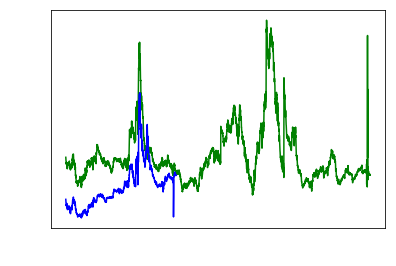

In [85]:
# 画图测试
rank1 = fund_narrow_pd.loc[(fund_narrow_pd[0] == "单位净值")]
rank2 = fund_narrow_pd.loc[(fund_narrow_pd[0] == "净值汇报")]

# rank = fund_narrow_pd.loc[(fund_narrow_pd[0] == "排名") & (fund_narrow_pd[1] == 3511)]

# xmajorLocator   = MultipleLocator(50) #将x主刻度标签设置为20的倍数
# xmajorFormatter = FormatStrFormatter('%1.1f') #设置x轴标签文本的格式
# xminorLocator   = MultipleLocator(5) #将x轴次刻度标签设置为5的倍数

# ymajorLocator   = MultipleLocator(50) #将y轴主刻度标签设置为0.5的倍数
# ymajorFormatter = FormatStrFormatter('%1.1f') #设置y轴标签文本的格式
# yminorLocator   = MultipleLocator(0.1) #将此y轴次刻度标签设置为0.1的倍数

fig = plt.figure()
ax = fig.add_subplot(111)
# print(rank.values[1])
ax.plot(rank1.values[0][2:-1], color='green', label=fund_narrow_pd[0])
ax.plot(rank1.values[1][2:-1], color='blue', label=fund_narrow_pd[0])
# ax.plot(rank.values[1][2:-1], color='blue', label=fund_narrow_pd[1])
# ax.plot(rank.values[2][2:-1], color='y', label=fund_narrow_pd[1])
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# ax.xaxis.set_major_locator(xmajorLocator)
# ax.xaxis.set_major_formatter(xmajorFormatter)
 
# ax.yaxis.set_major_locator(ymajorLocator)
# ax.yaxis.set_major_formatter(ymajorFormatter)

#设置坐标轴刻度
# my_x_ticks = np.arange(0, 700, 50) #显示范围为-5至5，每0.5显示一刻度
# my_y_ticks = np.arange(0, 1750, 100) #显示范围为-2至2，每0.2显示一刻度
# plt.xticks(my_x_ticks)
# plt.yticks(my_y_ticks)

# 设置刻度范围
# plt.xlim(0,700) 
# plt.ylim(0,500)
# ax.spines['bottom'].set_color('g')
# ax.spines['top'].set_color('blue')
ax.xaxis.label.set_color('w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')
plt.show()

In [ ]:
# 找出优质数据方法
# 找出有三年历史业绩的基金
rank = fund_narrow_pd.loc[(fund_narrow_pd[0] == "单位净值")]
rank = fund_narrow_pd.loc[(fund_narrow_pd[0] == "净值汇报")]

In [ ]:
# 暂时无用代码分割点

In [176]:
# 批量测试
# 广发聚祥灵活混合 000567
# 前海开源中证大农业指数增强 001027
# allCode = getAllCode()
# print(type(allCode))
# 存在就删除
if os.path.exists("./fund_narrow_pd.csv"):
    os.remove("./fund_narrow_pd.csv")
if os.path.exists("./fund_wide_pd.csv"):
    os.remove("./fund_wide_pd.csv")
    
allCode = ["000001","002552", "002553","005206","002591"]
for code in allCode:
    code, basic_info_pd, funds = getWorth(code)
    df_to_csv(code, basic_info_pd, funds)
#     try:
#         code, basic_info_pd, funds = getWorth(code)
#         df_to_csv(code, basic_info_pd, funds)
#     except:
#         continue
    if len(funds) <= 0:
        print(code + "'s' data is empty.")
#     continue
#     print("write " + code + "'s data success.")
    print("end")

华夏成长混合 000001
write 000001's data success.
end
华夏恒利定开债 002552
write 002552's data success.
end
博时创业成长混合C 002553
write 002553's data success.
end
南方优选成长混合C 005206
write 005206's data success.
end
中欧信用增利债券(LOF)E 002591
write 002591's data success.
end


In [178]:
# fund_narrow_pd3=pd.read_csv('./fund_narrow_pd.csv', low_memory=False, header = None)
fund_narrow_pd2=pd.read_csv('./fund_narrow_pd.csv', low_memory=False, header = None, error_bad_lines=False)
# fund_narrow_pd1=pd.read_csv('./fund_narrow_pd.csv', low_memory=False, header = None, delimiter="\t")
# fund_wide_pd=pd.read_csv('./fund_wide_pd_part.csv',low_memory=False, header = None)
# fund_narrow_pd.fillna(0)
# fund_wide_pd.fillna(0)
print("read OK")
# print(fund_narrow_pd1.shape)
# print(fund_narrow_pd2.shape)
print(fund_narrow_pd2.shape)

read OK
(55, 4306)


In [ ]:
## 单个调试

# netWorth, ACWorth, grandTota , fluctuationScaleList = getWorth1('003511')
code, basic_info_pd, funds = getWorth('003511')
# 007490
print("------",len(funds))
# netWorth, ACWorth = getWorth('003511')
# print(ACWorth)

In [335]:
# 有两部分
# 一部分是可以转平的，属性+信息
# 一部分是时间轴，n 个数据
# 共 13 个参数系列
# 是存 13 个文件，里面 n 个funds
# 还是存 1 个文件，里面是 13*n 个 funds
# 可以转平合并的，先合并
# 可以按照时间戳合并的，合并
# 理论上最后是 2 个文件，横向列一份，纵向时间轴一份
# 2*n

0    [[经验值, 反映基金经理从业年限和管理基金的经验, 67.2], [收益率, 根据基金经理...
1    [[经验值, 反映基金经理从业年限和管理基金的经验, 20], [收益率, 根据基金经理投资...
Name: 评分, dtype: object

In [615]:
# 数据合并到DF 单个基金版本
basic_info_pd.reset_index(drop=True)

stockCodesDF = pd.DataFrame([[funds[0]]], columns=['基金持仓股票代码'])
zqCodesDF = pd.DataFrame([[funds[1]]], columns=['基金持仓债券代码'])

netWorthDF = pd.DataFrame(
    funds[2], columns=['时间戳', '单位净值', '净值回报', '每份派送金'])
ACWorthDF = pd.DataFrame(funds[3], columns=['时间戳', '累计净值'])
grandTotalDF = pd.DataFrame(funds[4], columns=['累计收益率名称', '累计收益率信息'])
for i in range(len(grandTotalDF['累计收益率信息'])):
    grandTotalDF['累计收益率信息'][i] = pd.DataFrame(
        grandTotalDF['累计收益率信息'][i], columns=['时间戳', grandTotalDF['累计收益率名称'][i] + '累计收益率'])

rateInSimilarTypeDF = pd.DataFrame(funds[5], columns=['时间戳', '排名', 'sc'])
rateInSimilarPersentDF = pd.DataFrame(funds[6], columns=['同类排名百分比'])
fluctuationScaleDF = pd.DataFrame(
    funds[7], columns=['规模变动日期', "规模变动净资产亿元", "规模变动较上期环比"])

# 已平
holderStructureDF = pd.DataFrame(funds[8], columns=['持有信息日期', '持有信息'])
for i in range(len(holderStructureDF['持有信息'])):
    holderStructureDF['持有信息'][i] = pd.DataFrame(
        holderStructureDF['持有信息'][i], columns=["持有比名称", "比例"])
holderStructureDF = holderStructureDF.T
holderStructureDF.reset_index(drop=True, inplace=True)
holderStructureDF.columns = holderStructureDF[:1].values.tolist()
holderStructureDF = holderStructureDF.drop(0)
holderStructureDF = holderStructureDF.reset_index(drop=True)

# 已平
assetAllocationDF = pd.DataFrame(funds[9], columns=['名称', '资产配置名称'])
for i in range(len(assetAllocationDF['资产配置名称'])):
    assetAllocationDF['资产配置名称'][i] = pd.DataFrame(
        assetAllocationDF['资产配置名称'][i], columns=["时间", "比例"])
assetAllocationDF = assetAllocationDF.T
assetAllocationDF.reset_index(drop=True, inplace=True)
assetAllocationDF.columns = assetAllocationDF[:1].values.tolist()
assetAllocationDF = assetAllocationDF.drop(0)
assetAllocationDF = assetAllocationDF.reset_index(drop=True)

# 已平
performanceEvaluationDF = pd.DataFrame(funds[10]).T
performanceEvaluationDF = performanceEvaluationDF[0].apply(pd.Series)
performanceEvaluationDF.columns = ["业绩评价名称", "分数", "描述"]
performanceEvaluationDF = performanceEvaluationDF.T
performanceEvaluationDF.reset_index(drop=True, inplace=True)
performanceEvaluationDF.columns = performanceEvaluationDF[:1].values.tolist()
performanceEvaluationDF = performanceEvaluationDF.drop(0)
performanceEvaluationDF = performanceEvaluationDF.drop(2)
performanceEvaluationDF = performanceEvaluationDF.reset_index(drop=True)

# 现任基金经理 已平,但有两行
power_pd = pd.DataFrame()
profit_pd = pd.DataFrame()
currentFundManagerDF = pd.DataFrame(
    funds[11],
    columns=['id', '姓名', '星级', '工作时间', '资金/基金数', '平均分', '截止日期', '评分', '收益能力'])

for i in range(len(currentFundManagerDF["id"])):
    power = pd.DataFrame(currentFundManagerDF['评分'][i]).T
    power = power.drop(1)  # 删除描述
    power.columns = power[:1].values.tolist()  # 重命名列名
    power = power.drop(0)
    power.reset_index(drop=True, inplace=True)
    power_pd = pd.concat([power_pd, power])
    power_pd.reset_index(drop=True, inplace=True)

    profit = pd.DataFrame(currentFundManagerDF['收益能力'][i]).T
    profit.columns = profit[:1].values.tolist()  # 重命名列名
    profit = profit.drop(0)
    profit.reset_index(drop=True, inplace=True)
    profit_pd = pd.concat([profit_pd, profit])
    profit_pd.reset_index(drop=True, inplace=True)

currentFundManagerDF = pd.concat([currentFundManagerDF, power_pd], axis=1)
currentFundManagerDF = pd.concat([currentFundManagerDF, profit_pd], axis=1)
currentFundManagerDF = currentFundManagerDF.drop(['评分', '收益能力'], axis=1)
currentFundManagerDF = pd.DataFrame([currentFundManagerDF.T])

# 申购赎回 # 已平
buySedemptionDF = pd.DataFrame(funds[12], columns=['申购赎回日期', '申购赎回信息'])
for i in range(len(buySedemptionDF['申购赎回信息'])):
    buySedemptionDF['申购赎回信息'][i] = pd.DataFrame(
        buySedemptionDF['申购赎回信息'][i], columns=["时间", "份额"])
buySedemptionDF = buySedemptionDF.T
buySedemptionDF.reset_index(drop=True, inplace=True)
buySedemptionDF.columns = buySedemptionDF[:1].values.tolist()
buySedemptionDF = buySedemptionDF.drop(0)
buySedemptionDF = buySedemptionDF.reset_index(drop=True)

# 合并到最终宽窄两表
# 建立宽表 合并
fund_wide_pd = pd.DataFrame()
fund_wide_pd = pd.concat([fund_wide_pd, basic_info_pd], axis=1)
fund_wide_pd = pd.concat([fund_wide_pd, stockCodesDF], axis=1)  #
fund_wide_pd = pd.concat([fund_wide_pd, zqCodesDF], axis=1)  #
fund_wide_pd = pd.concat([
    fund_wide_pd,
    pd.DataFrame([[fluctuationScaleDF["规模变动日期"].values.tolist()]],
                 columns=["规模变动日期"])
], axis=1)
fund_wide_pd = pd.concat([
    fund_wide_pd,
    pd.DataFrame([[fluctuationScaleDF["规模变动净资产亿元"].values.tolist()]],
                 columns=["规模变动净资产亿元"])
],  axis=1)
fund_wide_pd = pd.concat([
    fund_wide_pd,
    pd.DataFrame([[fluctuationScaleDF["规模变动较上期环比"].values.tolist()]],
                 columns=["规模变动较上期环比"])
], axis=1)
fund_wide_pd = pd.concat([fund_wide_pd, holderStructureDF], axis=1)
fund_wide_pd = pd.concat([fund_wide_pd, assetAllocationDF], axis=1)
fund_wide_pd = pd.concat([fund_wide_pd, performanceEvaluationDF], axis=1)
fund_wide_pd = pd.concat([fund_wide_pd, currentFundManagerDF], axis=1)
fund_wide_pd.rename(columns={0: "经理"}, inplace=True)
fund_wide_pd = pd.concat([fund_wide_pd, buySedemptionDF], axis=1)
fund_wide_pd.to_csv('./fund_wide_pd.csv', encoding='utf_8_sig')


# 窄表
fund_narrow_pd = pd.DataFrame()
fund_narrow_pd = pd.concat([fund_narrow_pd,rateInSimilarTypeDF],axis=1)
fund_narrow_pd = pd.concat([fund_narrow_pd,rateInSimilarPersentDF],axis=1)
# fund_narrow_pd = pd.concat([fund_narrow_pd,netWorthDF],axis=1, join='outer', keys=['时间戳'])
fund_narrow_pd = pd.merge(fund_narrow_pd,netWorthDF,how='outer')
fund_narrow_pd = pd.merge(fund_narrow_pd,ACWorthDF,how='outer')

for i in range(len(grandTotalDF['累计收益率信息'])):
    fund_narrow_pd = pd.merge(fund_narrow_pd,grandTotalDF['累计收益率信息'][i],how='outer')
#     grandTotalDF['累计收益率信息'][i] = pd.DataFrame(
#         grandTotalDF['累计收益率信息'][i], columns=['时间戳', '累计收益率'])

fund_narrow_pd = pd.DataFrame(fund_narrow_pd.T)
# x1['code']='12'
fund_narrow_pd.insert(0,'code',code)
fund_narrow_pd.to_csv('./fund_narrow_pd.csv', encoding='utf_8_sig')

# fund_narrow_pd.to_csv('./fund_narrow_pd.csv', encoding='utf_8_sig')


# 保存 分散
# basic_info_pd.to_csv('./basic_info_pd.csv', encoding='utf_8_sig') # 宽
# stockCodesDF.to_csv('./stockCodesDF.csv', encoding='utf_8_sig') # 宽
# zqCodesDF.to_csv('./zqCodesDF.csv', encoding='utf_8_sig') # 宽
# netWorthDF.to_csv('./netWorthDF.csv', encoding='utf_8_sig') # 1 类
# ACWorthDF.to_csv('./ACWorthDF.csv', encoding='utf_8_sig')  # 1 类
# grandTotalDF.to_csv('./grandTotalDF.csv', encoding='utf_8_sig') # 3 类
# rateInSimilarTypeDF.to_csv('./rateInSimilarTypeDF.csv', encoding='utf_8_sig') # 2 类
# rateInSimilarPersentDF.to_csv('./rateInSimilarPersentDF.csv', encoding='utf_8_sig')# 2 类
# fluctuationScaleDF.to_csv(
#     './fluctuationScaleDF.csv', encoding='utf_8_sig')  # 宽
# holderStructureDF.to_csv('./holderStructureDF.csv', encoding='utf_8_sig') # 宽
# assetAllocationDF.to_csv('./assetAllocationDF.csv', encoding='utf_8_sig') # 宽
# performanceEvaluationDF.to_csv('./performanceEvaluationDF.csv', encoding='utf_8_sig') # 宽
# currentFundManagerDF.to_csv('./currentFundManagerDF.csv', encoding='utf_8_sig') # 宽
# buySedemptionDF.to_csv('./buySedemptionDF.csv', encoding='utf_8_sig') # 宽

In [ ]:
# import requests
# import time
# import execjs


# def getUrl(fscode):
#     head = 'http://fund.eastmoney.com/pingzhongdata/'
#     tail = '.js?v=' + time.strftime("%Y%m%d%H%M%S", time.localtime())
#     return head + fscode + tail


# # 根据基金代码获取净值
# def getWorth(fscode):
#     content = requests.get(getUrl(fscode))
#     jsContent = execjs.compile(content.text)

#     name = jsContent.eval('fS_name')
#     code = jsContent.eval('fS_code')
#     #单位净值走势
#     netWorthTrend = jsContent.eval('Data_netWorthTrend')
#     #累计净值走势
#     ACWorthTrend = jsContent.eval('Data_ACWorthTrend')

#     netWorth = []
#     ACWorth = []

#     for dayWorth in netWorthTrend[::-1]:
#         netWorth.append(dayWorth['y'])

#     for dayACWorth in ACWorthTrend[::-1]:
#         ACWorth.append(dayACWorth[1])
#     print(name, code)
#     return netWorth, ACWorth


# def getAllCode():
#     url = 'http://fund.eastmoney.com/js/fundcode_search.js'
#     content = requests.get(url)
#     jsContent = execjs.compile(content.text)
#     rawData = jsContent.eval('r')
#     allCode = []
#     for code in rawData:
#         allCode.append(code[0])
#     return allCode


allCode = getAllCode()

# netWorthFile = open('./netWorth.csv', 'w')
# ACWorthFile = open('./ACWorth.csv', 'w')

for code in allCode:
    try:
        netWorth, ACWorth = getWorth(code)
    except:
        continue
    if len(netWorth) <= 0 or len(ACWorth) < 0:
        print(code + "'s' data is empty.")
        continue
    netWorthFile.write("\'" + code + "\',")
    netWorthFile.write(",".join(list(map(str, netWorth))))
    netWorthFile.write("\n")

    ACWorthFile.write("\'" + code + "\',")
    ACWorthFile.write(",".join(list(map(str, ACWorth))))
    ACWorthFile.write("\n")
    print("write " + code + "'s data success.")
    

netWorthFile.close()
ACWorthFile.close()

华夏成长混合 000001
write 000001's data success.
中海可转债债券A 000003
write 000003's data success.
中海可转债债券C 000004
write 000004's data success.
嘉实增强信用定期债券 000005
write 000005's data success.
西部利得量化成长混合 000006
write 000006's data success.
嘉实中证500ETF联接A 000008
write 000008's data success.
华夏大盘精选混合 000011
write 000011's data success.
华夏聚利债券 000014
write 000014's data success.
华夏纯债债券A 000015
write 000015's data success.
华夏纯债债券C 000016
write 000016's data success.
财通可持续混合 000017
write 000017's data success.
景顺长城品质投资混合 000020
write 000020's data success.
华夏优势增长混合 000021
write 000021's data success.
大摩双利增强债券A 000024
write 000024's data success.
大摩双利增强债券C 000025
write 000025's data success.
华富安鑫债券 000028
write 000028's data success.
富国宏观策略灵活配置混合 000029
write 000029's data success.
长城核心优选混合 000030
write 000030's data success.
华夏复兴混合 000031
write 000031's data success.
易方达信用债债券A 000032
write 000032's data success.
易方达信用债债券C 000033
write 000033's data success.
农银高增长混合 000039
write 000039's data success.
华夏全